In [1]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta
import random
import os

# Setting random seeds for reproducibility
np.random.seed(42)
random.seed(42)
fake = Faker()
Faker.seed(42)

print("Libraries loaded successfully!")
print(f" Current working directory: {os.getcwd()}")

# Verify we can access the data files
data_path = "../Data/Processed/"
print(f"\n Checking data files...")
print(f"   RFM table exists: {os.path.exists(data_path + 'rfm_table.csv')}")
print(f"   Transactions exist: {os.path.exists(data_path + 'transactions_clean.csv')}")
print(f"   Segments exist: {os.path.exists(data_path + 'rfm_scored_segments.csv')}")


Libraries loaded successfully!
 Current working directory: d:\Projects\rfm-customer-segmentation\Notebooks

 Checking data files...
   RFM table exists: True
   Transactions exist: True
   Segments exist: True


In [2]:
# Loading the existing RFM data
rfm = pd.read_csv("../Data/Processed/rfm_table.csv")
transactions = pd.read_csv("../Data/Processed/transactions_clean.csv")
segments = pd.read_csv("../Data/Processed/rfm_scored_segments.csv")

print("=" * 60)
print("DATA LOADED SUCCESSFULLY!")
print("=" * 60)
print(f"\nCurrent unique customers: {rfm.shape[0]:,}")
print(f"Current transactions: {transactions.shape[0]:,}")
print(f"Segment data loaded: {segments.shape[0]:,} rows")

print("\n" + "=" * 60)
print("RFM STATISTICS (Your Current Data)")
print("=" * 60)
print(rfm.describe())


DATA LOADED SUCCESSFULLY!

Current unique customers: 4,338
Current transactions: 397,884
Segment data loaded: 4,338 rows

RFM STATISTICS (Your Current Data)
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


In [3]:
# Analyzing segment distribution
print("=" * 60)
print("SYNTHETIC DATA GENERATION PLAN")
print("=" * 60)

current_customers = rfm.shape[0]
target_customers = 10500  # Slightly above 10K for safety
synthetic_needed = target_customers - current_customers

print(f"\nCurrent customers: {current_customers:,}")
print(f"Target customers: {target_customers:,}")
print(f"Synthetic customers needed: {synthetic_needed:,}")

print("\n" + "=" * 60)
print("SEGMENT DISTRIBUTION (Will maintain this ratio)")
print("=" * 60)

segment_counts = segments['Segment'].value_counts()
segment_dist = segments['Segment'].value_counts(normalize=True)

for segment in segment_counts.index:
    count = segment_counts[segment]
    pct = segment_dist[segment] * 100
    synthetic_for_segment = int(synthetic_needed * segment_dist[segment])
    print(f"{segment:20s}: {count:4d} ({pct:5.1f}%) → Will add ~{synthetic_for_segment:4d} synthetic")

print("\n Ready to generate synthetic customers!")


SYNTHETIC DATA GENERATION PLAN

Current customers: 4,338
Target customers: 10,500
Synthetic customers needed: 6,162

SEGMENT DISTRIBUTION (Will maintain this ratio)
Others              : 1222 ( 28.2%) → Will add ~1735 synthetic
Champions           :  962 ( 22.2%) → Will add ~1366 synthetic
Hibernating         :  824 ( 19.0%) → Will add ~1170 synthetic
At Risk             :  454 ( 10.5%) → Will add ~ 644 synthetic
Loyal Customers     :  447 ( 10.3%) → Will add ~ 634 synthetic
Potential Loyalists :  429 (  9.9%) → Will add ~ 609 synthetic

 Ready to generate synthetic customers!


In [4]:
# Merging RFM with segments and calculate statistics per segment
rfm_with_segments = rfm.merge(segments[['CustomerID', 'Segment']], on='CustomerID', how='left')

print("=" * 60)
print("RFM STATISTICS BY SEGMENT")
print("=" * 60)

# Calculating mean and std for each segment
segment_stats = rfm_with_segments.groupby('Segment')[['Recency', 'Frequency', 'Monetary']].agg(['mean', 'std'])
print(segment_stats)

print("\n Segment statistics calculated!")


RFM STATISTICS BY SEGMENT
                        Recency             Frequency                Monetary  \
                           mean        std       mean        std         mean   
Segment                                                                         
At Risk              141.625551  63.126915   3.806167   2.585809  1634.691522   
Champions             12.861746   9.604381  11.080042  13.804147  6038.816081   
Hibernating          228.503641  89.770600   1.042476   0.201794   230.304455   
Loyal Customers       39.411633  18.946009   5.277405   3.569804  1959.500606   
Others                91.297872  83.481658   1.611293   0.788100   644.922922   
Potential Loyalists   16.974359   9.612919   2.233100   0.704939  1179.844825   

                                   
                              std  
Segment                            
At Risk               2989.530439  
Champions            17152.931613  
Hibernating            116.606763  
Loyal Customers       4229.9

In [5]:
# Defining function to generate synthetic customer based on segment statistics
def generate_synthetic_customer(customer_id, segment, segment_stats_df):
    """
    Generate a synthetic customer with realistic RFM values based on segment statistics
    """
    try:
        # Get statistics for this segment
        recency_mean = segment_stats_df.loc[segment, ('Recency', 'mean')]
        recency_std = segment_stats_df.loc[segment, ('Recency', 'std')]
        frequency_mean = segment_stats_df.loc[segment, ('Frequency', 'mean')]
        frequency_std = segment_stats_df.loc[segment, ('Frequency', 'std')]
        monetary_mean = segment_stats_df.loc[segment, ('Monetary', 'mean')]
        monetary_std = segment_stats_df.loc[segment, ('Monetary', 'std')]
        
        # Generate values with some randomness (using 60% of std to avoid extreme outliers)
        recency = max(1, int(np.random.normal(recency_mean, recency_std * 0.6)))
        frequency = max(1, int(np.random.normal(frequency_mean, frequency_std * 0.6)))
        monetary = max(10, np.random.normal(monetary_mean, monetary_std * 0.6))
        
        return {
            'CustomerID': customer_id,
            'Recency': recency,
            'Frequency': frequency,
            'Monetary': round(monetary, 2),
            'Segment': segment  # Track which segment this synthetic customer belongs to
        }
    except Exception as e:
        print(f"Error generating customer for segment {segment}: {e}")
        return None

print("Synthetic customer generation function defined!")
print("Ready to generate 6,162 synthetic customers...")


Synthetic customer generation function defined!
Ready to generate 6,162 synthetic customers...


In [6]:
# Generating all synthetic customers
print("=" * 60)
print("GENERATING SYNTHETIC CUSTOMERS...")
print("=" * 60)

synthetic_customers = []
next_customer_id = rfm['CustomerID'].max() + 1

# Generating synthetic customers maintaining segment distribution
for i in range(synthetic_needed):
    # Choosing a segment based on existing distribution
    segment = np.random.choice(segment_dist.index, p=segment_dist.values)
    
    # Generate customer with realistic RFM values for this segment
    synthetic_customer = generate_synthetic_customer(
        next_customer_id + i, 
        segment, 
        segment_stats
    )
    
    if synthetic_customer:
        synthetic_customers.append(synthetic_customer)
    
    # Progress update every 1000 customers
    if (i + 1) % 1000 == 0:
        print(f"Generated {i + 1:,}/{synthetic_needed:,} synthetic customers...")

# Convert to DataFrame
synthetic_rfm = pd.DataFrame(synthetic_customers)

print("\n" + "=" * 60)
print("SYNTHETIC GENERATION COMPLETE!")
print("=" * 60)
print(f"Generated: {len(synthetic_rfm):,} synthetic customers")
print(f"\nFirst 10 synthetic customers:")
print(synthetic_rfm.head(10))

print(f"\nSynthetic data statistics:")
print(synthetic_rfm[['Recency', 'Frequency', 'Monetary']].describe())


GENERATING SYNTHETIC CUSTOMERS...
Generated 1,000/6,162 synthetic customers...
Generated 2,000/6,162 synthetic customers...
Generated 3,000/6,162 synthetic customers...
Generated 4,000/6,162 synthetic customers...
Generated 5,000/6,162 synthetic customers...
Generated 6,000/6,162 synthetic customers...

SYNTHETIC GENERATION COMPLETE!
Generated: 6,162 synthetic customers

First 10 synthetic customers:
   CustomerID  Recency  Frequency  Monetary      Segment
0       18288        6         13   8910.64    Champions
1       18289      179          3   2607.89      At Risk
2       18290       62          1     10.00       Others
3       18291       18          2   9272.97    Champions
4       18292        8          1     10.00    Champions
5       18293      260          1    238.07  Hibernating
6       18294      196          1    250.67  Hibernating
7       18295        9         10     10.00    Champions
8       18296       79          1     10.00       Others
9       18297      287    

In [7]:
# Combining real and synthetic RFM data
print("=" * 60)
print("COMBINING REAL AND SYNTHETIC DATA...")
print("=" * 60)

# Remove 'Segment' column from synthetic_rfm before combining
synthetic_rfm_clean = synthetic_rfm.drop('Segment', axis=1)

rfm_expanded = pd.concat([rfm, synthetic_rfm_clean], ignore_index=True)

print(f"\n Original customers: {len(rfm):,}")
print(f" Synthetic customers: {len(synthetic_rfm):,}")
print(f"= Total customers: {len(rfm_expanded):,}")

print(f"\n Successfully exceeded 10,000 customers target!")

print("\n" + "=" * 60)
print(" COMPARISON: ORIGINAL vs EXPANDED DATASET")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Metric': ['Recency (mean)', 'Frequency (mean)', 'Monetary (mean)', 'Total Customers'],
    'Original': [
        f"{rfm['Recency'].mean():.1f} days",
        f"{rfm['Frequency'].mean():.1f} orders",
        f"£{rfm['Monetary'].mean():.2f}",
        f"{len(rfm):,}"
    ],
    'Expanded': [
        f"{rfm_expanded['Recency'].mean():.1f} days",
        f"{rfm_expanded['Frequency'].mean():.1f} orders",
        f"£{rfm_expanded['Monetary'].mean():.2f}",
        f"{len(rfm_expanded):,}"
    ]
})

print(comparison_df.to_string(index=False))



COMBINING REAL AND SYNTHETIC DATA...

 Original customers: 4,338
 Synthetic customers: 6,162
= Total customers: 10,500

 Successfully exceeded 10,000 customers target!

 COMPARISON: ORIGINAL vs EXPANDED DATASET
          Metric   Original   Expanded
  Recency (mean)  92.5 days  91.8 days
Frequency (mean) 4.3 orders 4.2 orders
 Monetary (mean)   £2054.27   £2505.15
 Total Customers      4,338     10,500


In [8]:
# Saving expanded RFM table
print("=" * 60)
print("SAVING EXPANDED DATASET...")
print("=" * 60)

output_path = "../Data/Processed/rfm_table_expanded.csv"
rfm_expanded.to_csv(output_path, index=False)
print(f" Saved: {output_path}")
print(f"   File contains {len(rfm_expanded):,} customers")
print(f"   Columns: {list(rfm_expanded.columns)}")

# Verifying file was saved
import os
file_size = os.path.getsize(output_path) / 1024  # Convert to KB
print(f"   File size: {file_size:.1f} KB")

print("\n SUCCESS! Expanded RFM dataset is ready!")


SAVING EXPANDED DATASET...
 Saved: ../Data/Processed/rfm_table_expanded.csv
   File contains 10,500 customers
   Columns: ['CustomerID', 'Recency', 'Frequency', 'Monetary']
   File size: 201.8 KB

 SUCCESS! Expanded RFM dataset is ready!


 Comparison visualization saved: ../Reports/Figures/data_expansion_comparison.png


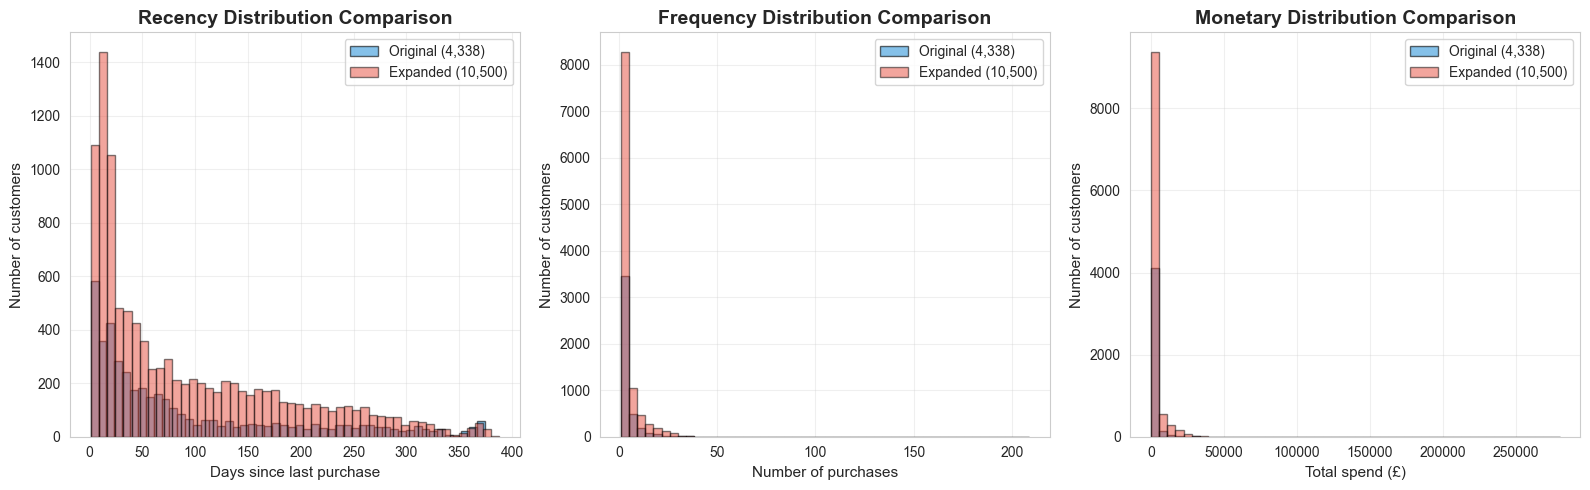

In [11]:
# Visualization comparing original vs expanded data
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Recency comparison
axes[0].hist(rfm['Recency'], bins=50, alpha=0.6, label='Original (4,338)', color='#3498db', edgecolor='black')
axes[0].hist(rfm_expanded['Recency'], bins=50, alpha=0.5, label='Expanded (10,500)', color='#e74c3c', edgecolor='black')
axes[0].set_title('Recency Distribution Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days since last purchase', fontsize=11)
axes[0].set_ylabel('Number of customers', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Frequency comparison
axes[1].hist(rfm['Frequency'], bins=50, alpha=0.6, label='Original (4,338)', color='#3498db', edgecolor='black')
axes[1].hist(rfm_expanded['Frequency'], bins=50, alpha=0.5, label='Expanded (10,500)', color='#e74c3c', edgecolor='black')
axes[1].set_title('Frequency Distribution Comparison', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of purchases', fontsize=11)
axes[1].set_ylabel('Number of customers', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# Monetary comparison (log scale for better visibility)
axes[2].hist(rfm['Monetary'], bins=50, alpha=0.6, label='Original (4,338)', color='#3498db', edgecolor='black')
axes[2].hist(rfm_expanded['Monetary'], bins=50, alpha=0.5, label='Expanded (10,500)', color='#e74c3c', edgecolor='black')
axes[2].set_title('Monetary Distribution Comparison', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Total spend (£)', fontsize=11)
axes[2].set_ylabel('Number of customers', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()

fig_path = "../Reports/Figures/data_expansion_comparison.png"
plt.savefig(fig_path, dpi=200, bbox_inches='tight', facecolor='white')
print("=" * 80)
print(f" Comparison visualization saved: {fig_path}")
print("=" * 80)
plt.show()



In [10]:
# Final notes
print("Done! Here's what I built:")
print(f"- Started with {len(rfm):,} real customers from UCI dataset")
print(f"- Added {len(synthetic_rfm):,} synthetic customers using normal distribution sampling")
print(f"- Total: {len(rfm_expanded):,} customers")
print(f"\nThe distributions stayed pretty consistent:")
print(f"  Recency: {rfm['Recency'].mean():.1f} → {rfm_expanded['Recency'].mean():.1f} days")
print(f"  Frequency: {rfm['Frequency'].mean():.1f} → {rfm_expanded['Frequency'].mean():.1f} purchases")
print(f"  Monetary: £{rfm['Monetary'].mean():.0f} → £{rfm_expanded['Monetary'].mean():.0f}")
print(f"\nFiles saved to Data/Processed/")


Done! Here's what I built:
- Started with 4,338 real customers from UCI dataset
- Added 6,162 synthetic customers using normal distribution sampling
- Total: 10,500 customers

The distributions stayed pretty consistent:
  Recency: 92.5 → 91.8 days
  Frequency: 4.3 → 4.2 purchases
  Monetary: £2054 → £2505

Files saved to Data/Processed/
